# Bivariate Observations

Insurers are typically exposed to more than one type of risk, and it can be beneficial for them to consider the joint risk profile for related products.

This example considers a joint model for the frequency of claims reported for two nonlife insurance portfolios.
The claim counts are Poisson distributed  with respective intensity $\Lambda w_1$ and $\Lambda w_2$ where $\Lambda$ is some non-negative random variable.

The frequency data $(n_1,m_1),\ldots, (n_t,m_t)$ is i.i.d. according to a bivariate counting distribution with joint p.m.f. given by

$$
p_{N,M}(n,m) = \int\frac{\mathrm{e}^{-\lambda w_1}(\lambda w_1)^n}{n!}\frac{\mathrm{e}^{-\lambda w_2}(\lambda w_2)^m}{m!} \mathrm{d} \mathbb{P}_\Lambda(\lambda), \quad n,m = 0, 1, \dots.
$$

The severities associated to a given time period $s=1,\ldots, t$ form two mutually independent, i.i.d. sequences of exponentially distributed random variables,

$$
U_{s,1},\ldots, U_{s,n_s} \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exp}(m_1 = 10) \quad \text{and} \quad
V_{s,1},\ldots, V_{s,m_s} \overset{\mathrm{i.i.d.}}{\sim} \mathsf{Exp}(m_2 = 70).
$$

Each observation then is a pair of numbers corresponding to the aggregate claims for each risk.
That is,

$$
X_s = \Bigl( \sum_{i=1}^{N_s} U_{s,i} , \sum_{i=1}^{M_s} V_{s,i} \Bigr)
$$

## Generate synthetic observations

We start by importing some necessary packages.

In [1]:
%config InlineBackend.figure_format = 'retina'
import approxbayescomp as abc
import numpy as np
import numpy.random as rnd

/Users/plaub/approxbayescomp/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will fit simulated data, so that we know the true value of the parameters for the data-generating process.
We let $\Lambda$ be a lognormal random variable $\mathsf{Lognormal}(\sigma=0.2)$ (the mean log parameter is set to $0$) as it is consistent with the use of a generalized linear model equipped with a log link function to estimate the Poisson intensity given a set of covariates.
The marginal components of the claim frequency distribution are set to $w_1 = 15$ and $w_2 = 5$.
Finally, we observe $T = 250$ i.i.d. bivariate observations.

In [2]:
# Create a pseudorandom number generator
rg = rnd.default_rng(1234)

# Parameters of the true model
freq = "bivariate poisson"
sev = "exponential"
σ = 0.2
w1 = 15
w2 = 5
m1 = 10
m2 = 70
trueTheta = (σ, w1, w2, m1, m2)

# Setting the time horizon
T = 250

# Simulating the claim data
claimsData = abc.simulate_claim_data(rg, T, freq, sev, trueTheta)

# Simulating the observed data
psi = abc.Psi("sum")

xData1 = abc.compute_psi(claimsData[0][0], claimsData[0][1], psi)
xData2 = abc.compute_psi(claimsData[1][0], claimsData[1][1], psi)

xData = np.vstack([xData1, xData2]).T

We can see if any of this observed data contains pesky zeros:

In [3]:
np.sum(xData == 0)

4

Also, as we have bivariate data, we will use a special distance function which expects to receive a matrix with two columns:

In [4]:
xData.shape

(250, 2)

## Use ABC to fit the data

With this data, we create objects to represent the data-generating process (the model) and the prior distribution.
The priors are set as

$$\sigma \sim \mathsf{Unif}(0, 2), \quad w_1 \sim \mathsf{Unif}(0, 50), \quad w_2 \sim \mathsf{Unif}(0, 50)$$
$$m_1 \sim \mathsf{Unif}(0, 100), \quad \text{ and } \quad m_2 \sim \mathsf{Unif}(0, 100).$$

In [5]:
model = abc.Model(freq, sev, psi)
params = ("$\\delta$", "$w_1$", "$w_2$", "$m_1$", "$m_2$")
prior = abc.IndependentUniformPrior([(0, 2), (0, 50), (0, 50), (0, 100), (0, 100)], params)

Finally, we call the main `smc` method to fit the observed `xData`.

### Ignoring the zeros

In [7]:
numIters = 10
popSize = 250
%time fit = abc.smc(numIters, popSize, xData, model, prior, distance=abc.wasserstein2D, numProcs=8, seed=1, verbose=True)

Starting ABC-SMC with population size of 250 and sample size of 250 (~> 500) on 8 processes.
Finished sampling from prior, eps = 2308.21, time = 4.0s / 0.1m, popSize = 250 -> 125, ESS = 250 -> 125, # sims = 250, total # sims = 250
Finished SMC iteration 1, eps = 680.92, time = 2.0s / 0.0m, popSize = 403 -> 135, ESS = 369 -> 125, # sims = 2248, total # sims = 2498
Finished SMC iteration 2, eps = 311.83, time = 1.0s / 0.0m, popSize = 402 -> 143, ESS = 340 -> 125, # sims = 4104, total # sims = 6602
Finished SMC iteration 3, eps = 198.09, time = 2.0s / 0.0m, popSize = 402 -> 156, ESS = 312 -> 125, # sims = 6920, total # sims = 13522
Finished SMC iteration 4, eps = 137.68, time = 3.0s / 0.1m, popSize = 443 -> 171, ESS = 339 -> 125, # sims = 12808, total # sims = 26330
Finished SMC iteration 5, eps = 102.23, time = 7.0s / 0.1m, popSize = 422 -> 166, ESS = 315 -> 125, # sims = 23816, total # sims = 50146
Finished SMC iteration 6, eps = 79.80, time = 11.0s / 0.2m, popSize = 423 -> 159, ESS = 3

These particles all generated fake data within the following distance to the observed data:

In [8]:
np.max(fit.dists)

35.54484952368373

Plotting the fitted ABC posterior:

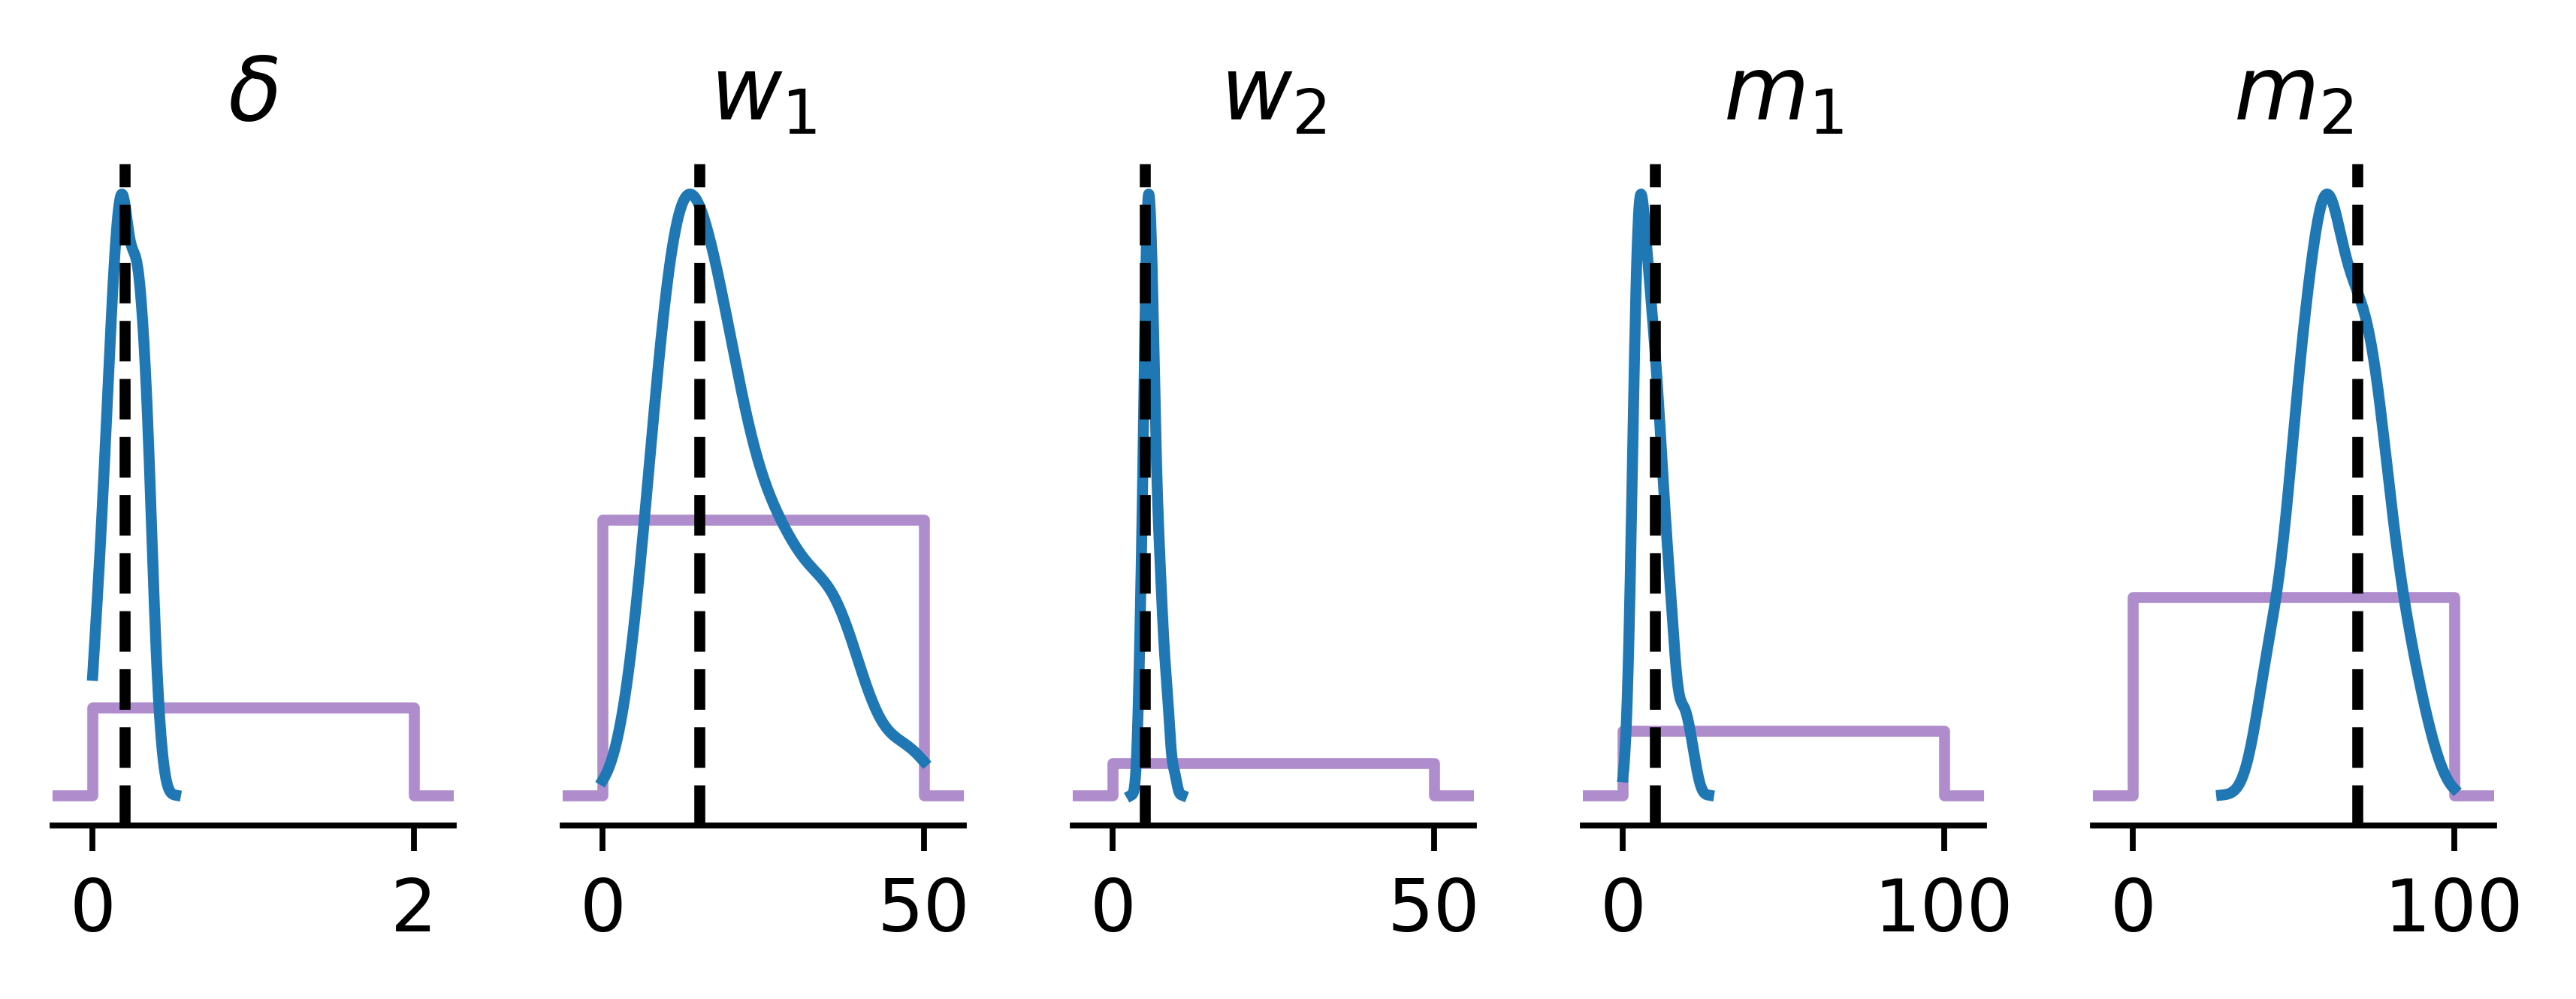

In [9]:
abc.plot_posteriors(
    fit,
    prior,
    refLines=trueTheta,
)

### Matching the zeros

Trying a second time with the `matchZeros` flag on:

In [10]:
%time fitMatchZeros = abc.smc(numIters, popSize, xData, model, prior, matchZeros=True, distance=abc.wasserstein2D, numProcs=8, seed=1, verbose=True)

Starting ABC-SMC with population size of 250 and sample size of 250 (~> 500) on 8 processes.
Finished sampling from prior, eps = 2308.21, time = 1.0s / 0.0m, popSize = 250 -> 125, ESS = 250 -> 125, # sims = 250, total # sims = 250
Finished SMC iteration 1, eps = 803.98, time = 2.0s / 0.0m, popSize = 377 -> 136, ESS = 340 -> 125, # sims = 242088, total # sims = 242338
Finished SMC iteration 2, eps = 304.74, time = 2.0s / 0.0m, popSize = 410 -> 136, ESS = 373 -> 125, # sims = 242088, total # sims = 484426
Finished SMC iteration 3, eps = 155.41, time = 3.0s / 0.0m, popSize = 455 -> 142, ESS = 408 -> 125, # sims = 242088, total # sims = 726514
Finished SMC iteration 4, eps = 86.32, time = 4.0s / 0.1m, popSize = 559 -> 136, ESS = 505 -> 125, # sims = 242088, total # sims = 968602
Finished SMC iteration 5, eps = 46.57, time = 8.0s / 0.1m, popSize = 1226 -> 134, ESS = 994 -> 125, # sims = 242088, total # sims = 1210690
Finished SMC iteration 6, eps = 35.65, time = 10.0s / 0.2m, popSize = 1027

These particles all generated fake data within the following distance to the observed data:

In [11]:
np.max(fitMatchZeros.dists)

29.1217535245939

Plotting the fitted ABC posterior:

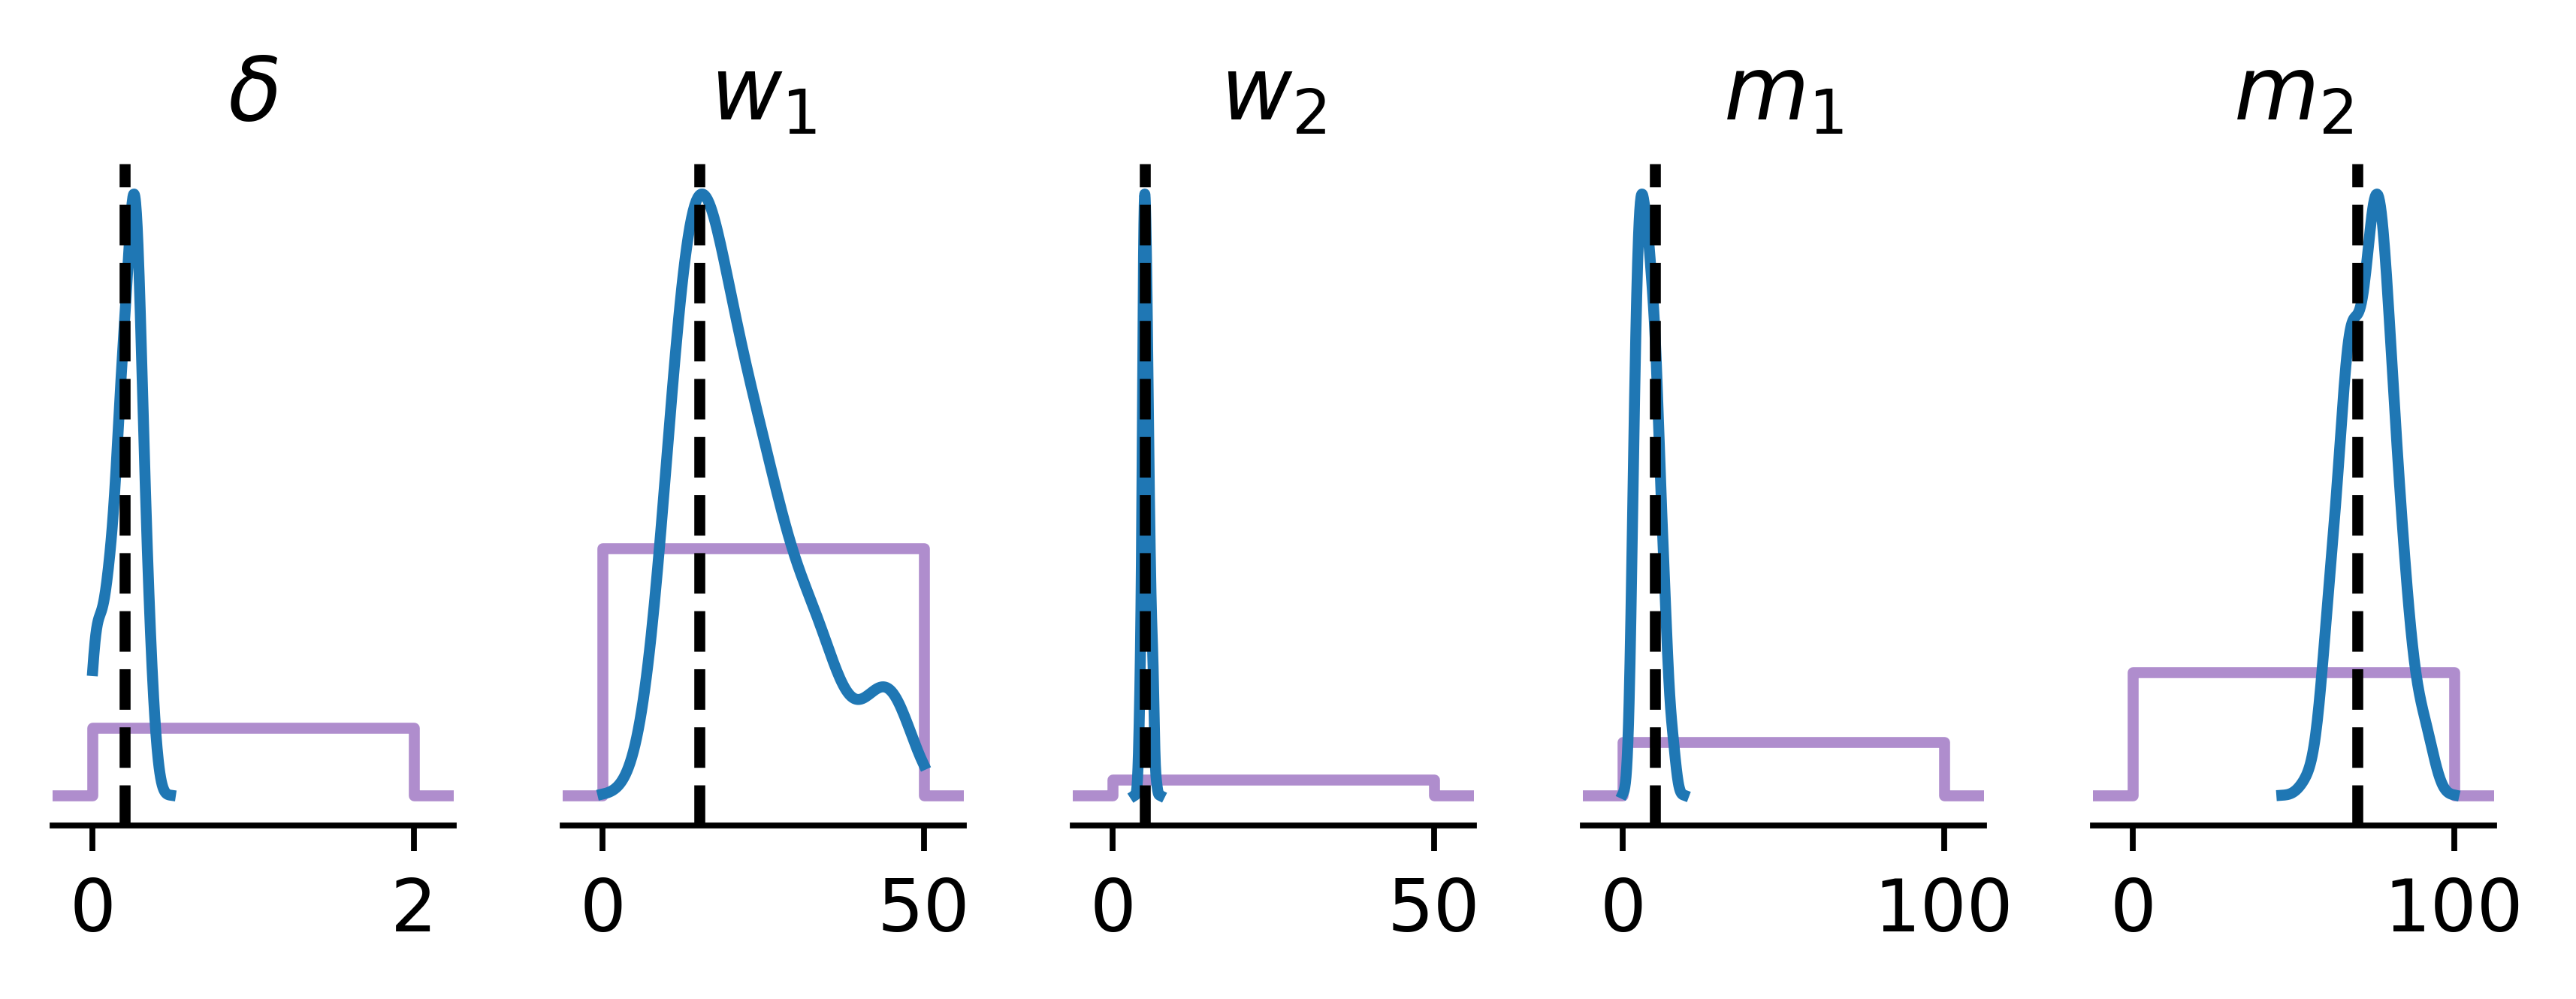

In [12]:
abc.plot_posteriors(
    fitMatchZeros,
    prior,
    refLines=trueTheta,
)

In this case, the `matchZeros` is much more accurate than the previous fit.